In [1]:
import pandas as pd
import numpy as np
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from utils import table_translate

dataset = pd.read_csv('./datas/dataset.csv', dtype={'股票代码':'object'})
needs = ['净资产收益率（ROE）B', '投入资本回报率（ROIC）', '成本费用利润率', '资产报酬率B', '总资产周转率B', '应付账款周转率B', '应收账款周转率B', '存货周转率B', '资产负债率', '现金资产比率','董事会规模','独董比例','净利润增长率B','速动比率', '权益乘数',  '营运指数',  '固定资产增长率B', '营业总收入增长率', '营业费用增长率', '财务杠杆', '经营杠杆', '研发人员数量占比(%)', '研发营收比(%)','申请专利数', '提供岗位增长率', '员工收入增长率', '股权集中度4(%)', '两权分离度(%)', '本期采购额占年度采购总额比例(%)', '本期销售额占年度销售总额比例(%)', '数字技术应用', '互联网商业模式', '智能制造', '现代信息系统']

# 指标逆向化
for name in ['应收账款周转率B', '存货周转率B', '资产负债率','营业费用增长率']:
    max_ = dataset[name].max()
    dataset[name] = dataset[name].apply(lambda x:max_-x)

mo_all, kmo_model = calculate_kmo(dataset[needs])
chi_square, p = calculate_bartlett_sphericity(dataset[needs])

# 保存一下部分案例数据
# show = dataset[dataset['股票代码'].isin(['000030','000049','000070','000333'])][['股票代码','截止年份','净资产收益率（ROE）B','投入资本回报率（ROIC）','申请专利数','智能制造','现代信息系统']].set_index(['股票代码','截止年份'])
# show = normalize(show,neg_vec=[], pass_vec=['股票代码','截止年份'],method='z').reset_index().round(3)
# table_translate(show)

print(f"KMO统计量的值为：{kmo_model:.4f}")
print(f"在{p}的显著水平下，近似卡方{chi_square:.2f}，球形检验拒绝相关阵为单位阵的原假设，说明做因子分析的效果还可以。")

KMO统计量的值为：0.7578
在0.0的显著水平下，近似卡方40743.37，球形检验拒绝相关阵为单位阵的原假设，说明做因子分析的效果还可以。


In [1]:
from sklearn.decomposition import KernelPCA
from scipy.stats import zscore

matrix = dataset[needs]
Xscale = zscore(matrix, ddof=1)
# Xscale = (matrix - np.mean(matrix, axis=0)) / np.std(matrix, axis=0)
kpca = KernelPCA(kernel='poly', n_components=Xscale.shape[1],degree=3)
# kernel 核函数 poly 代表多项式核函数  K(x,z) = [γ(xz+1)+r]^p
# γ由gamma参数确定，p由degree=3参数确定，r由coef0参数确定
# 一般 gamma 取1
kpca.fit(Xscale)

eigdt = pd.DataFrame(kpca.eigenvalues_, columns=['eig_value'],index=[i+1 for i in range(Xscale.shape[1])])
eigdt['cumlam'] = eigdt['eig_value'].apply(lambda x: x/eigdt['eig_value'].sum())
eigdt['ccve'] = eigdt['cumlam'].cumsum()
eigdt

NameError: name 'dataset' is not defined

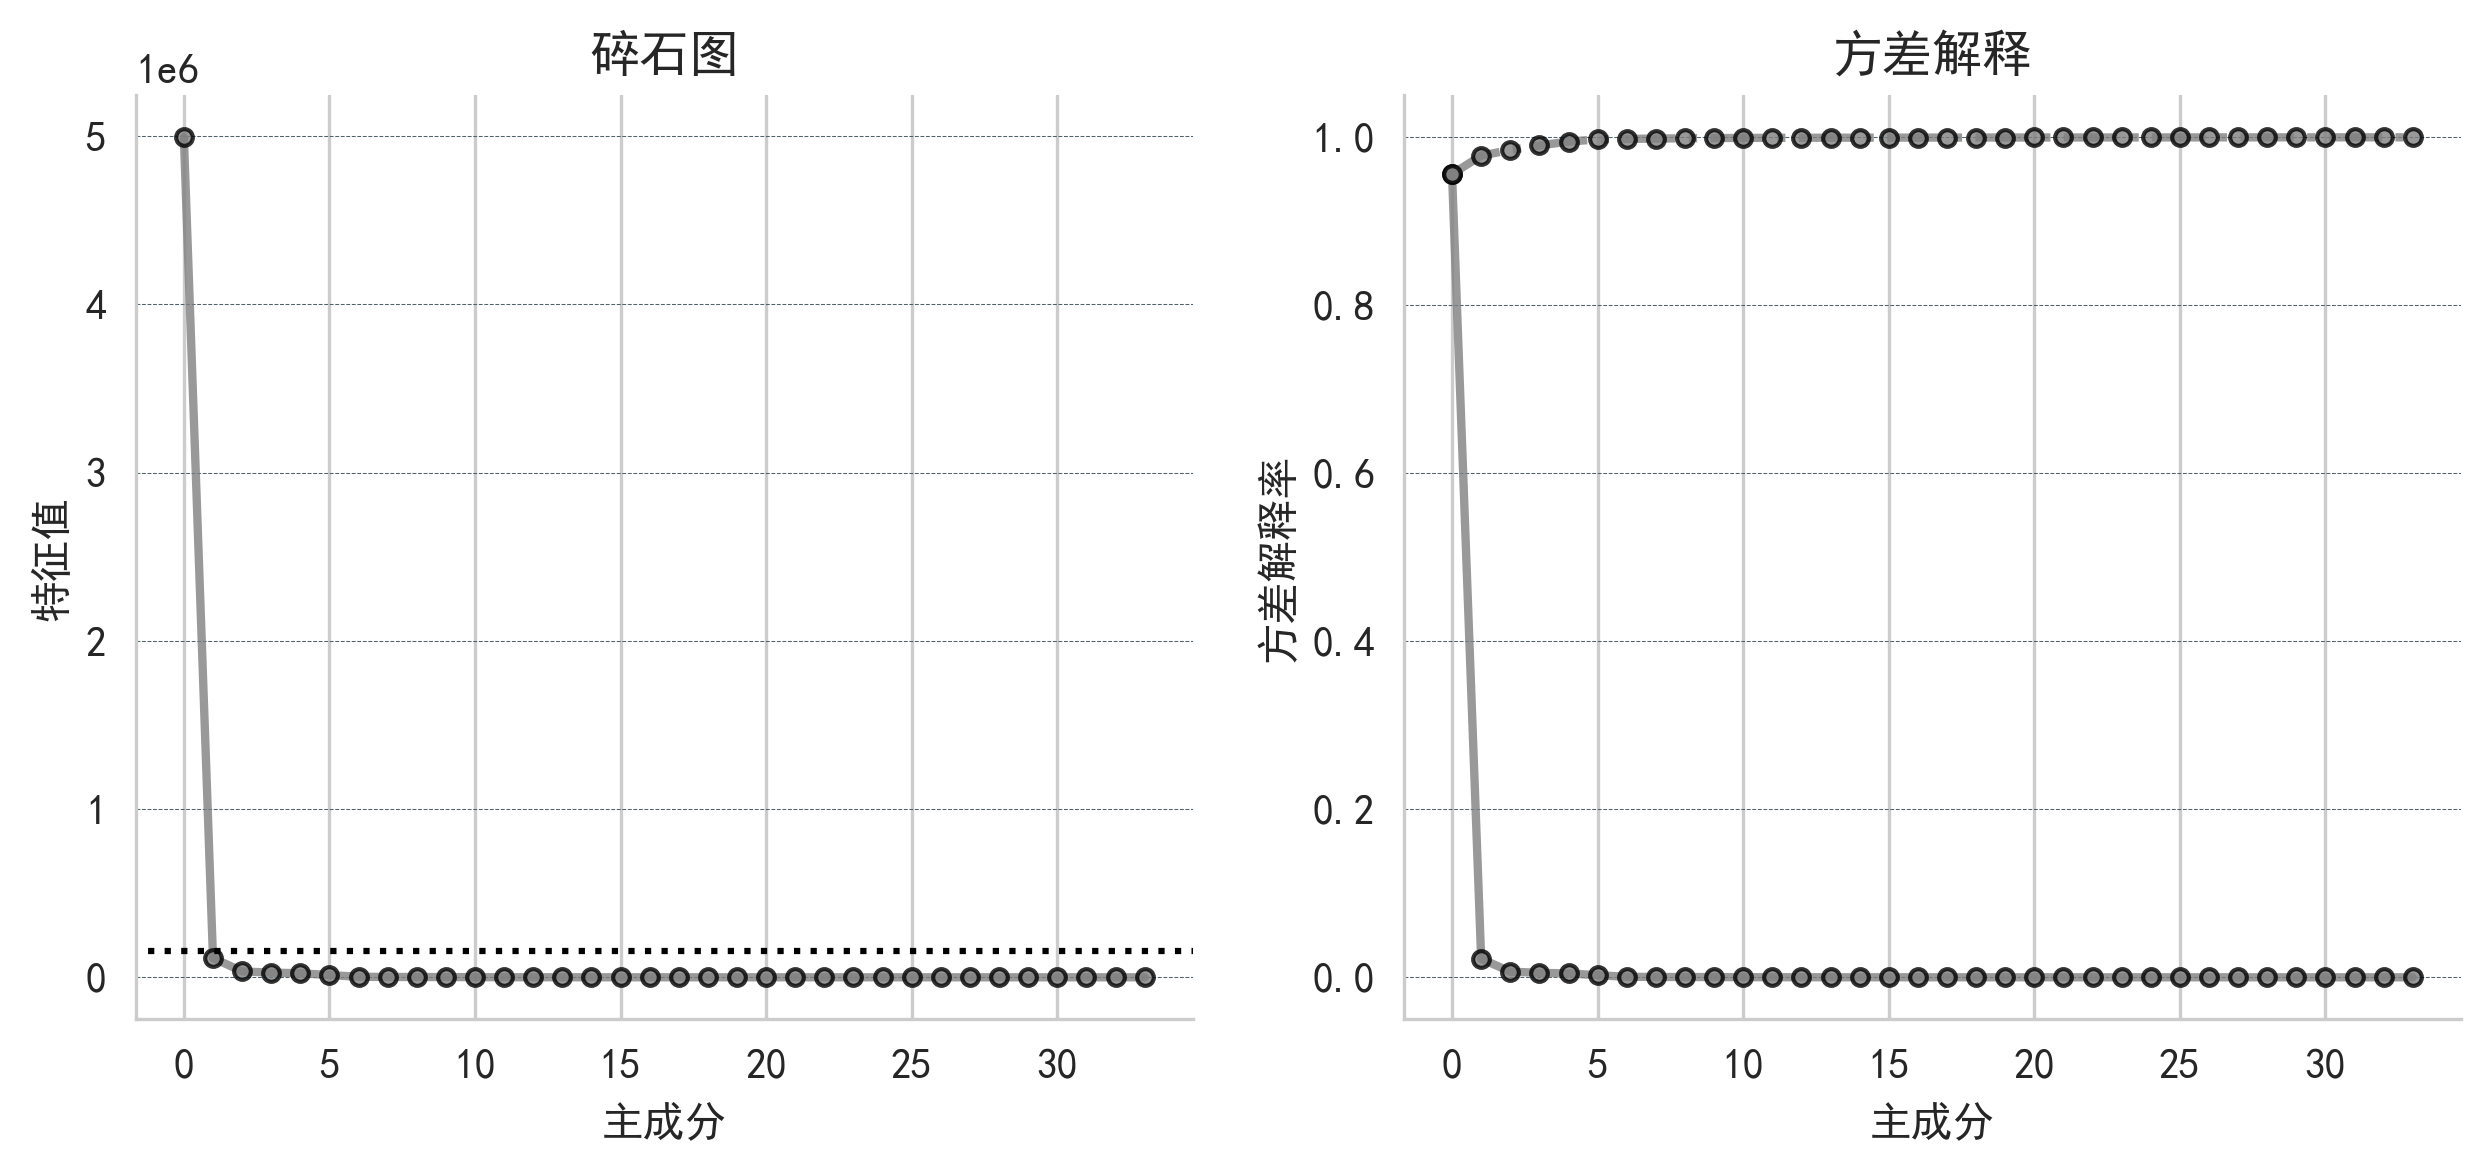

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    # 用来正常显示负号

# 输出一下碎石图
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=300)

alpha=0.8
linewidth=2
color = 'grey'
marker = "o"
markersize = '4'
markeredgecolor = 'k'
markeredgewidth = 1
names = [i for i in range(len(eigdt))]
ax1.plot(names, eigdt['eig_value'], linestyle='-', linewidth=linewidth, color=color , marker =marker,markeredgecolor=markeredgecolor, alpha=alpha,markersize=markersize,markeredgewidth=markeredgewidth)
ax2.plot(names, eigdt['cumlam'],linestyle='-', linewidth=linewidth, color=color , marker =marker,markeredgecolor=markeredgecolor,alpha=alpha,markersize=markersize,markeredgewidth=markeredgewidth)
ax2.plot(names, eigdt['ccve'],linestyle='-.', linewidth=linewidth, color=color , marker =marker,markeredgecolor=markeredgecolor,alpha=alpha,markersize=markersize, markeredgewidth=markeredgewidth)

ax1.axhline(y=eigdt['eig_value'].sum()/len(eigdt['eig_value']), xmin=-1.5, xmax=10, color='black', linestyle=':')

ax1.grid(ls = "--",axis='y', lw = 0.25, color = "#4E616C")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel("主成分")
ax1.set_ylabel("特征值")
ax1.set_title("碎石图", fontsize=12)

ax2.grid(ls = "--", axis='y', lw = 0.25, color = "#4E616C")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("主成分")
ax2.set_ylabel("方差解释率")
ax2.set_title("方差解释", fontsize=12)

plt.show()

In [5]:
# 计算最终得分
n_pcl=1
dataset['score'] = kpca.transform(Xscale)[:,:n_pcl]
# dataset['score'] = kpca.transform(Xscale)[:,:n_pcl].dot(kpca.explained_variance_ratio_[:n_pcl])
# dataset.sort_values('score', ascending=False, inplace=True)
# dataset.head(5)

In [6]:
from sklearn.model_selection import train_test_split
from utils import normalize

matrix = normalize(dataset, neg_vec=[], pass_vec=['股票代码','截止年份','score'])
Xnames = ['净资产收益率（ROE）B', '投入资本回报率（ROIC）', '成本费用利润率', '资产报酬率B', '总资产周转率B', '应付账款周转率B', '应收账款周转率B', '存货周转率B', '资产负债率', '速动比率', '权益乘数', '现金资产比率', '营运指数', '净利润增长率B', '固定资产增长率B', '营业总收入增长率', '营业费用增长率', '财务杠杆', '经营杠杆', '研发人员数量占比(%)', '研发营收比(%)', '提供岗位增长率', '员工收入增长率', '股权集中度4(%)', '两权分离度(%)', '董事会规模', '独董比例', '本期采购额占年度采购总额比例(%)', '本期销售额占年度销售总额比例(%)', '申请专利数','数字技术应用', '互联网商业模式', '智能制造', '现代信息系统']

X = matrix[Xnames]
y = matrix['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [7]:
from sklearn.metrics import mean_squared_error # 均方误差
from sklearn.neural_network import MLPRegressor


N = X_train.shape[0]
m = X_train.shape[1]
n = 1
a1,a2=1,3
start = int(N/(1+m)*a1)
layris = int(N/(1+m)*a2)
print(start, layris)
best_sizes = (start,)
best_score = 0
scores=[]
val_mses=[]
mses=[]
# tanh
for i in range(start, layris):
    model = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(i,), random_state=132, max_iter=100000)
    # model = MLPRegressor(activation='tanh', solver='adam', hidden_layer_sizes=(i, ), random_state=132, max_iter=100000)
    # model = MLPRegressor(activation='relu', solver='adam',alpha=0.2, hidden_layer_sizes=(i, ), random_state=132, max_iter=100000)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    val_mse = mean_squared_error(y_test, model.predict(X_test))
    mse = mean_squared_error(y_train, model.predict(X_train))
    scores.append(score)
    mses.append(mse)
    val_mses.append(val_mse)
    if best_score < score:
        best_score = score
        best_sizes = (i, )



print(best_sizes, best_score, '0.9794670370670062')

29 88
(29,) 0 0.9794670370670062


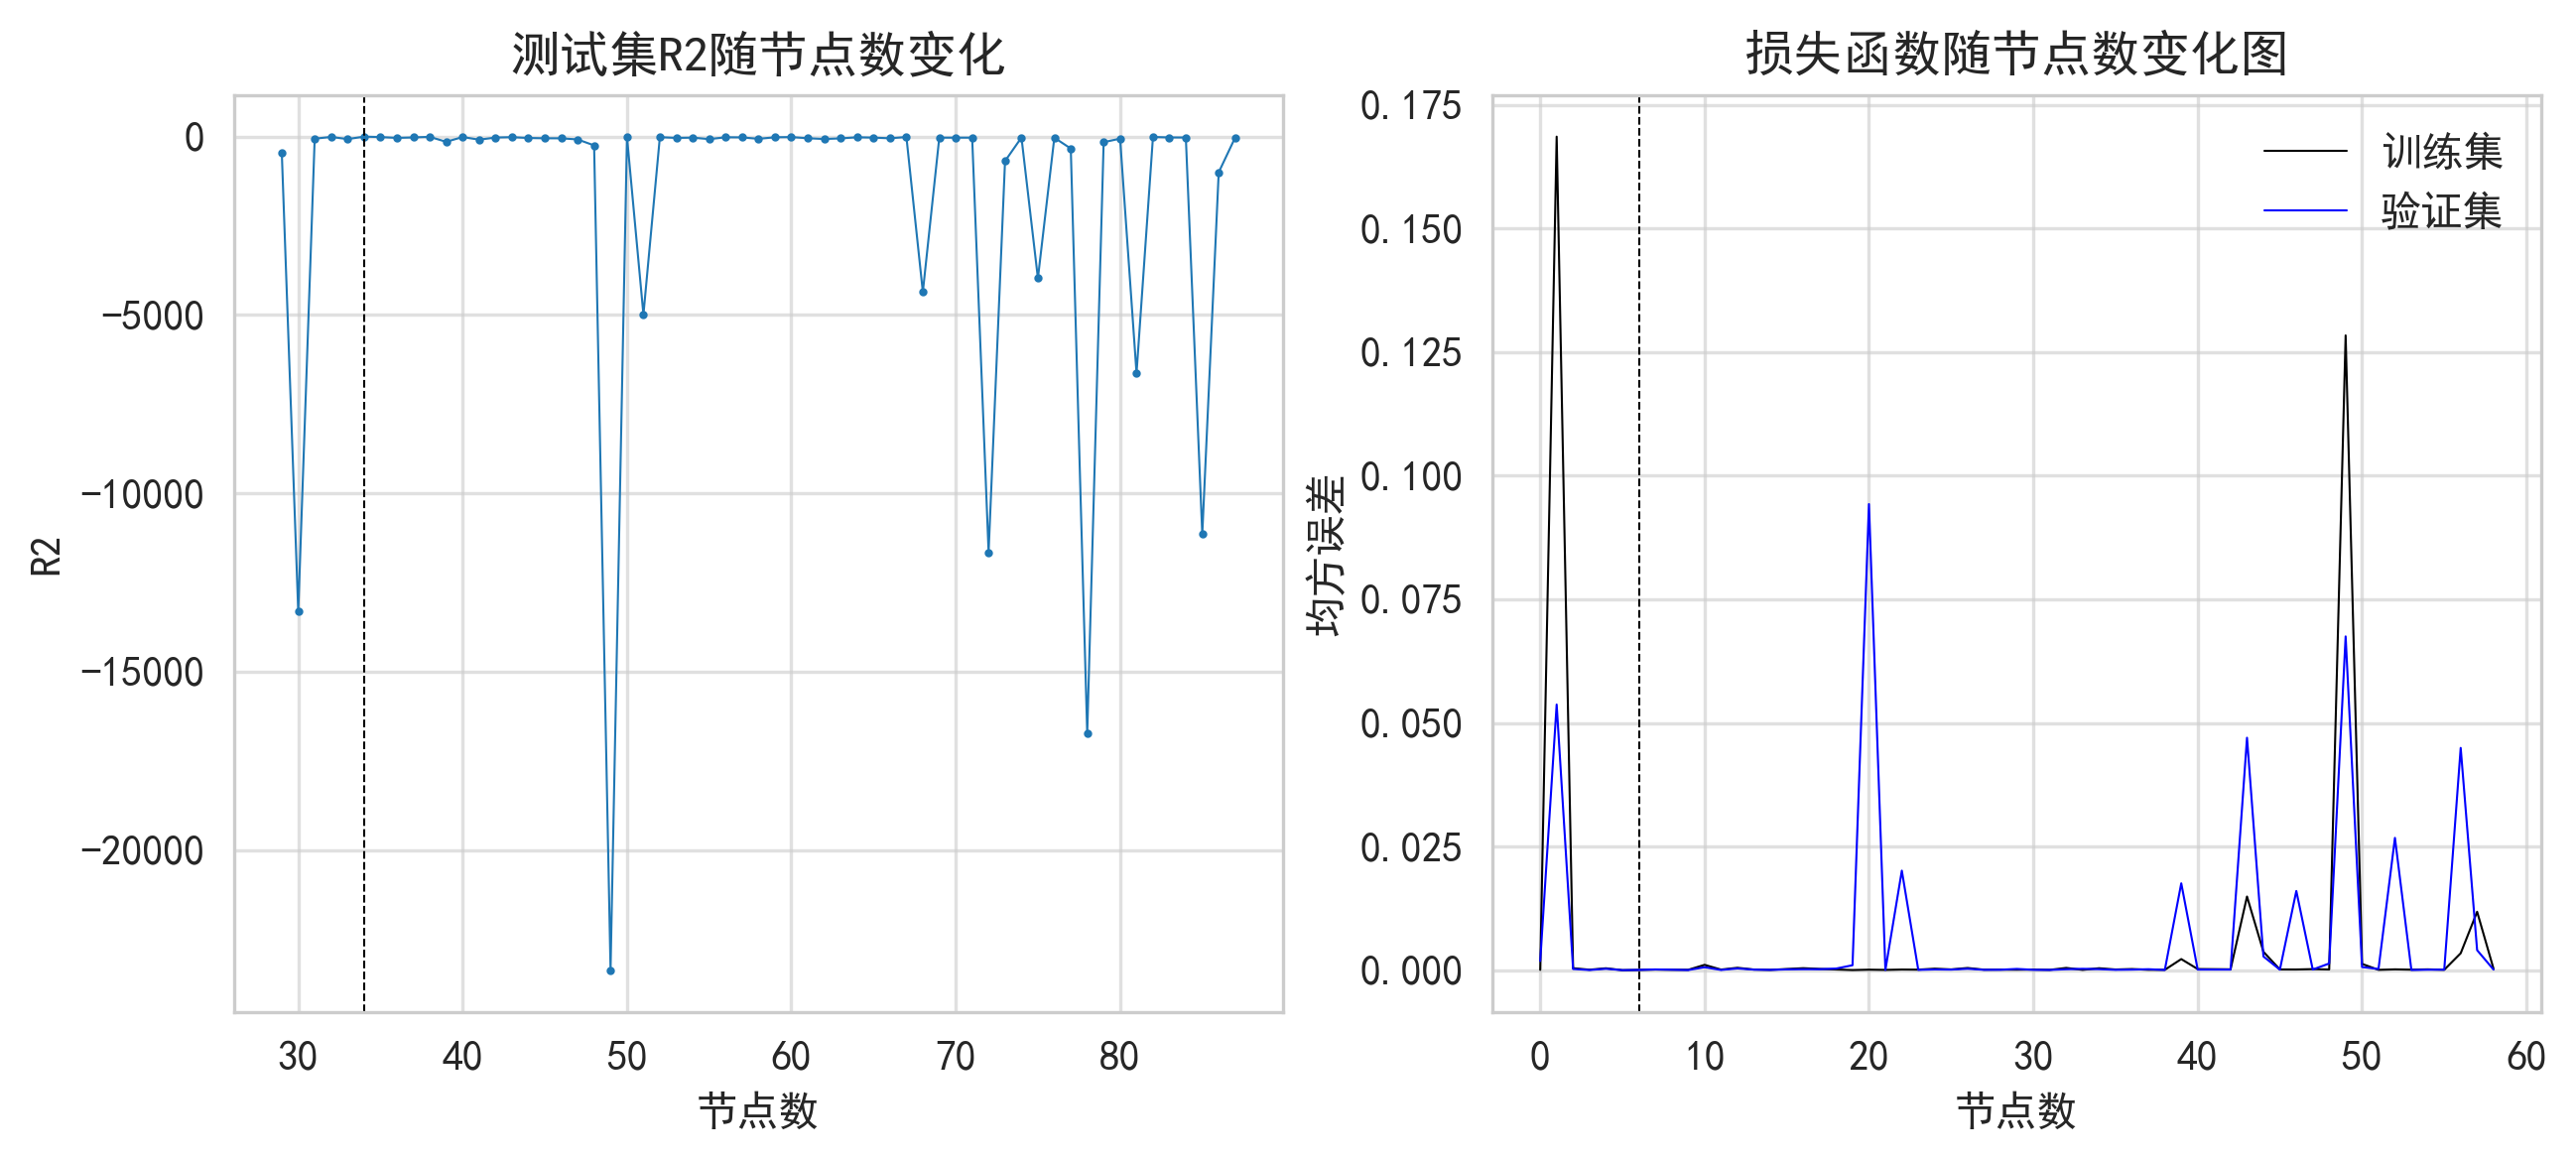

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    # 用来正常显示负号


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=300)
index = np.argmax(scores)
index2 = np.argmin(val_mses)

ax[0].plot(range(start, layris), scores, 'o-', linewidth=0.5, markersize=1)
ax[0].axvline(range(start, layris)[index], linestyle='--', color='k', linewidth=0.5)
ax[0].set_xlabel('节点数')
ax[0].set_ylabel('R2')
ax[0].set_title('测试集R2随节点数变化')

ax[1].plot(mses,'k', label='训练集', linewidth=0.5)
ax[1].plot(val_mses,'b', label='验证集', linewidth=0.5)
ax[1].axvline(index2+1, linestyle='--', color='k', linewidth=0.5)
ax[1].set_ylabel('均方误差')
ax[1].set_xlabel('节点数')
ax[1].set_title('损失函数随节点数变化图')
ax[0].grid(True, alpha=0.6)
ax[1].grid(True, alpha=0.6)
plt.legend(frameon=False)
# plt.savefig('./imgs/训练过程中的R方变化与损失函数的变化情况图.png', transparent=True,bbox_inches='tight')
plt.show()

R方:-13.93457; 迭代次数2402


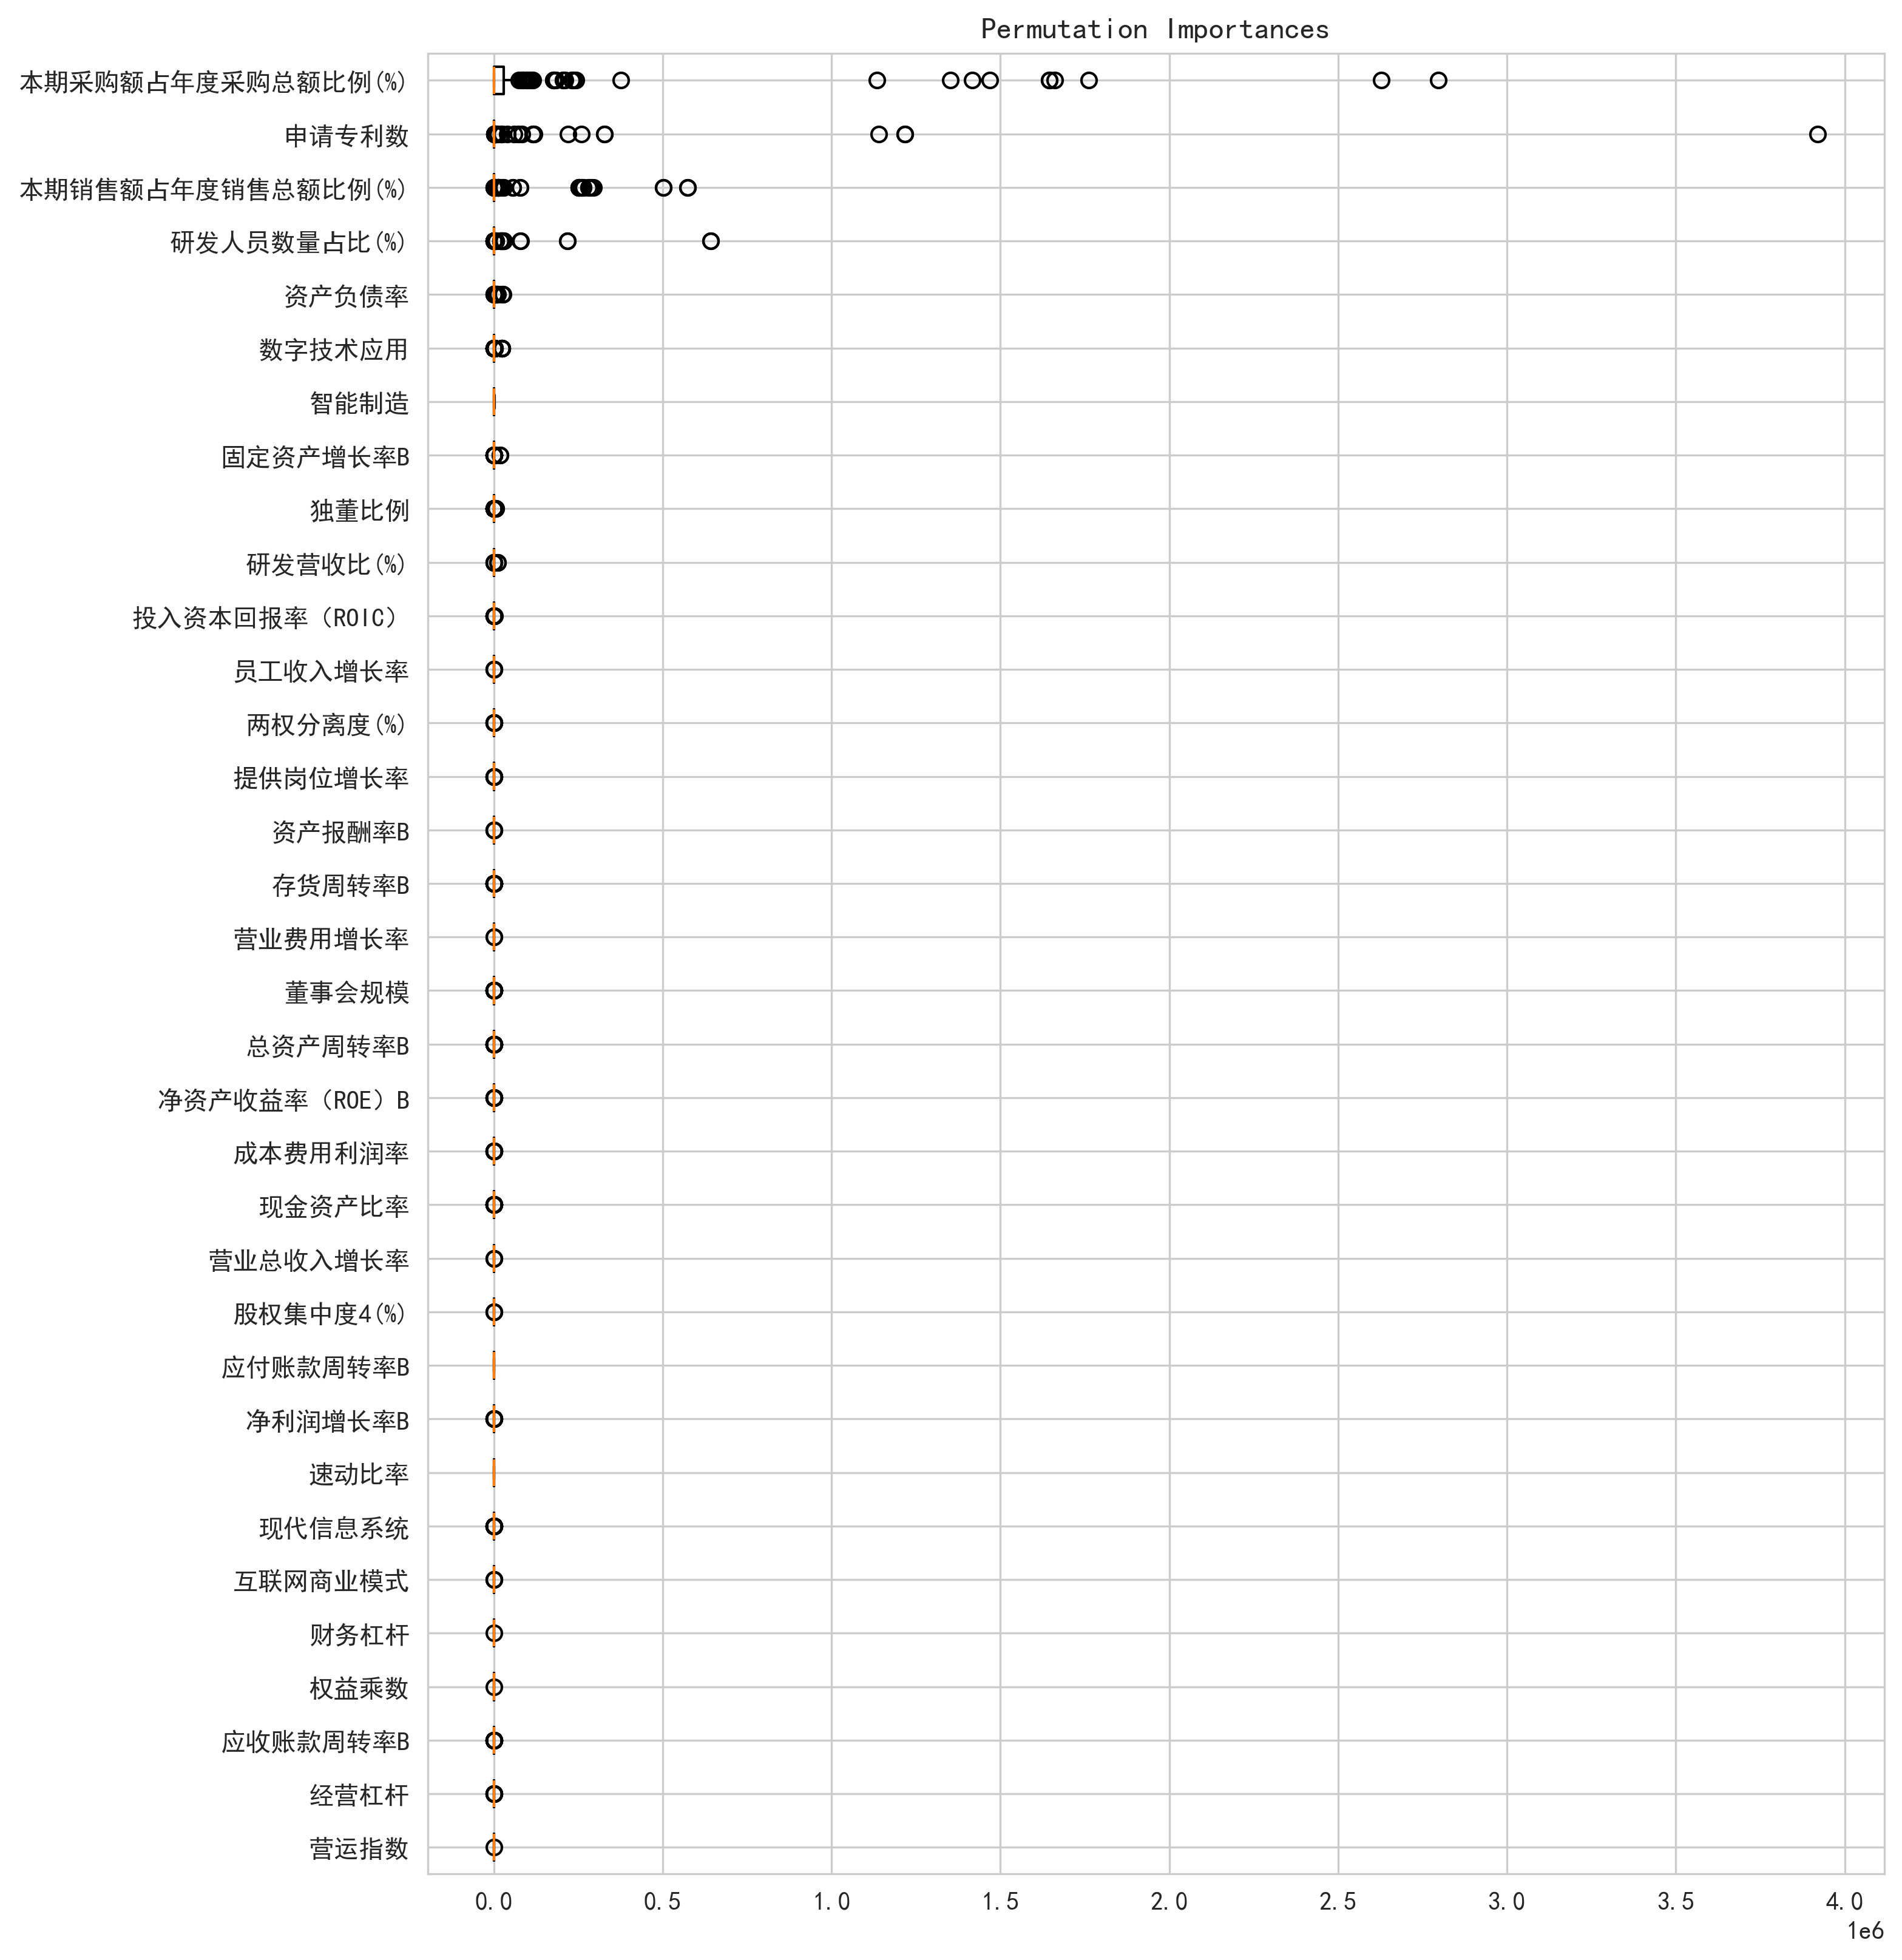

In [28]:
# 重要性
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

# model = MLPRegressor(activation='relu', solver='adam', hidden_layer_sizes=(211, ), random_state=132, max_iter=100000)
model = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(29,), random_state=132, max_iter=100000)
model.fit(X_train, y_train) 
print(f"R方:{model.score(X_test, y_test):.5f}; 迭代次数{model.n_iter_}")
Bunch_result = permutation_importance(model, X_test, y_test, n_repeats=200, random_state=42)

# n_repeats=20：进行50次随机替换
# Bunch_result:[importance(置换重要度),importance_mean（置换重要度均值）,importance_std（置换重要度标准差）]

Bunch_index = Bunch_result.importances_mean.argsort()
nlabels = [Xnames[i] for i in Bunch_index]

fig = plt.figure(figsize=(8,10), dpi=300)
ax = fig.add_axes([0, 0, 1, 1])

# Bunch_index = Bunch_result.importances_mean.argsort()
ax.boxplot(Bunch_result.importances[Bunch_index].T, vert=False, labels=nlabels)  #  labels=Xnames
plt.title('Permutation Importances')
# plt.savefig('./imgs/节点重要性分析.png', transparent=True,bbox_inches='tight')
plt.show()

In [ ]:
import seaborn as sns
# # 节点权重
fig = plt.figure(figsize=(15, 10),dpi=300)
ax = fig.add_axes([0,0,1,1])

table = pd.DataFrame(model.coefs_[0], index=Xnames, columns=[i for i in range(1,best_sizes[0]+1)])
sns.heatmap(table.abs(), cmap='Blues', annot=True)
ax.set_xlabel('Neuron')
ax.set_title('Neural Network Weights')
plt.tight_layout()

# # sns.heatmap(abs(table), cmap='Blues', annot=True)
# # plt.xlabel('Neuron')
# # plt.title('Neural Network Weights (Absolute Values)')
# # plt.tight_layout()
plt.show()